In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
!pip install super-gradients==3.2.0
!pip install pytube --upgrade
!pip install -q supervision

In [3]:
%%capture
import supervision as sv
from super_gradients.training import models
import os
import torch
import yaml
import cv2

In [4]:
#Global variables
HOME = os.getcwd()
CONFIDENCE_TRESHOLD=0.5
IMAGE_PATH = f"/{HOME}/drive/MyDrive/soccerNet_yolo8_dataset_new/test/images/100.png"
INPUT_VIDEO_PATH= f"/{HOME}/drive/MyDrive/videos for test /wimbeldon2.mp4"
OUTPUT_VIDEO_PATH = f"/{HOME}/drive/MyDrive/videos for test /results/wimbeldon2.mp4"

In [5]:
with open(f"{HOME}/data.yaml",'r') as yaml_file:
    yaml_data=yaml.load(yaml_file,Loader=yaml.FullLoader)

#to map classes_id with classes names to be annotated on images
classes_names = dict(zip(range(len(yaml_data["names"])),yaml_data["names"]))
classes_names

{0: 'Player',
 1: 'Goalkeeper',
 2: 'Ball',
 3: 'Main referee',
 4: 'Side referee',
 5: 'Staff members'}

In [6]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

#load the fine_tuned model
model = models.get('yolo_nas_l', num_classes=len(yaml_data['names']),
                             checkpoint_path=f"/{HOME}/drive/MyDrive/best model/average_model.pth")


In [7]:
# inference on images
def inference_on_images(image_path):
    # Load the image
    image = cv2.imread(image_path)
    # Perform inference on the image
    result = list(model.predict(image, conf=CONFIDENCE_TRESHOLD))[0]
    predictions = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )

    # Create a BoxAnnotator
    box_annotator = sv.BoxAnnotator()

    # Annotate the image with model predictions
    frame_with_predictions = box_annotator.annotate(
        scene=image.copy(),
        detections=predictions,
        labels=[f"{classes_names[class_id]}" for _, _, _, class_id, _ in predictions],
        skip_label=False
    )
    # Display the annotated image with model predictions
    %matplotlib inline
    sv.plot_image(frame_with_predictions)
    # Save the annotated image to a file
    annotated_image_path = f"/{HOME}/annotated_image.jpg"
    cv2.imwrite(annotated_image_path, frame_with_predictions)
    saved_image = cv2.imread(annotated_image_path)

# inference on video
def inference_on_video(input_video_path,output_video_path):
  model.to(device).predict(input_video_path,conf=CONFIDENCE_TRESHOLD,fuse_model=False).save(output_video_path)

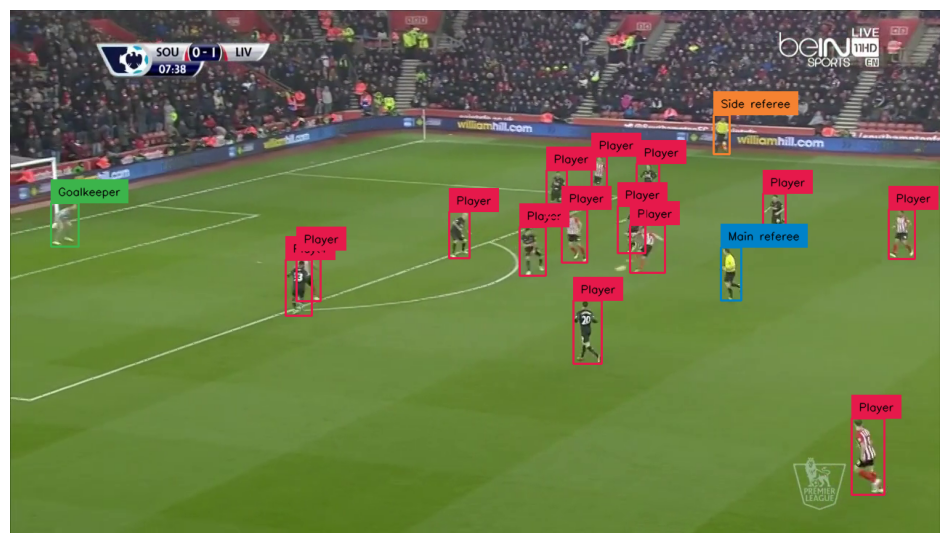

In [8]:
inference_on_images(IMAGE_PATH)

In [ ]:
inference_on_video(INPUT_VIDEO_PATH,OUTPUT_VIDEO_PATH)

Predicting Video: 100%|██████████| 923/923 [00:46<00:00, 19.84it/s]
